In [4]:
# SVM modeling pipeline (classification)
# Run this in one cell (or break into logical cells for presentation)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay)
import warnings
warnings.filterwarnings("ignore")

In [11]:
# ---------- 0) Load data ----------
df_path = r"C:\Users\imasha\Desktop\AI_SVM\final_dataset.csv"  # adjust path if needed
df = pd.read_csv(df_path)
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (1000, 34)
Columns: ['UserID', 'Age', 'Gender', 'Location', 'Income', 'Debt', 'Owns Property', 'Profession', 'Demographics', 'Platform', 'Total Time Spent', 'Number of Sessions', 'Video ID', 'Video Category', 'Video Length', 'Engagement', 'Importance Score', 'Time Spent On Video', 'Number of Videos Watched', 'Scroll Rate', 'Frequency', 'ProductivityLoss', 'Satisfaction', 'Watch Reason', 'DeviceType', 'OS', 'Watch Time', 'Self Control', 'Addiction Level', 'CurrentActivity', 'ConnectionType', 'AvgTimePerSession', 'EngagementPerVideo', 'EngagementPerVideo_Log']


In [12]:
# ---------- 1) Identify target ----------
# Try a set of common target column names; change/add names if needed
TARGET_CANDIDATES = ["Addiction", "Addiction Level", "Target", "label", "target", "Outcome"]
target_col = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    print("\nNo default target column found. Please set `target_col` manually to your target column name.")
    print("Columns available:", df.columns.tolist())
    raise SystemExit("Set target_col and re-run the cell.")

print("\nUsing target column:", target_col)


Using target column: Addiction Level


In [13]:
# ---------- 2) Basic preprocessing ----------
# 2.1 Drop identifier columns if present
id_cols = ["UserID", "ID", "user_id"]
for c in id_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)
        print(f"Dropped identifier column: {c}")

# 2.2 Separate X and y
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# 2.3 Encode target if non-numeric (binary classification assumed)
if y.dtype == object or y.dtype.name == "category":
    le_target = LabelEncoder()
    y = le_target.fit_transform(y.astype(str))
    print("Target classes (label encoded):", dict(enumerate(le_target.classes_)))

Dropped identifier column: UserID


In [14]:
# ---------- 3) Handle remaining missing values (simple, robust) ----------
# Numeric: fill with median; Categorical: fill with mode
for col in X.columns:
    if X[col].dtype in ["int64", "float64", "float32", "int32"]:
        X[col] = X[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna(X[col].mode()[0])

In [15]:
# ---------- 4) Encode categorical features ----------
# We'll do robust encoding: label-encode binary, one-hot for multi-class
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print("Categorical columns detected:", cat_cols)

# For binary categories, LabelEncode; for >2 unique, OneHot
onehot_cols = []
for c in cat_cols:
    if X[c].nunique() <= 2:
        X[c] = LabelEncoder().fit_transform(X[c].astype(str))
    else:
        onehot_cols.append(c)

if onehot_cols:
    X = pd.get_dummies(X, columns=onehot_cols, drop_first=True)
    print("One-hot encoded columns:", onehot_cols)

print("Feature matrix shape after encoding:", X.shape)

Categorical columns detected: ['Location', 'Debt', 'Owns Property', 'Profession', 'Video Category', 'Frequency', 'Watch Reason', 'DeviceType', 'OS', 'Watch Time', 'CurrentActivity', 'ConnectionType']
One-hot encoded columns: ['Location', 'Profession', 'Video Category', 'Frequency', 'Watch Reason', 'DeviceType', 'OS', 'Watch Time', 'CurrentActivity']
Feature matrix shape after encoding: (1000, 77)


In [16]:
# ---------- 5) Train-test split ----------
# Use stratify if y is classification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (800, 77) Test shape: (200, 77)


In [17]:
# ---------- 6) Scaling (important for SVM) ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# ---------- 7) Baseline SVM (linear) ----------
svc_baseline = SVC(kernel="linear", probability=True, random_state=42)
svc_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = svc_baseline.predict(X_test_scaled)

print("\nBaseline (linear kernel) performance:")
print(classification_report(y_test, y_pred_baseline, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_baseline))


Baseline (linear kernel) performance:
              precision    recall  f1-score   support

           0     0.9474    1.0000    0.9730        36
           1     0.6923    0.7500    0.7200        12
           2     0.9200    0.9200    0.9200        50
           3     0.9667    0.9062    0.9355        32
           4     0.8333    0.7143    0.7692         7
           5     0.8958    0.9556    0.9247        45
           6     0.5000    0.5714    0.5333         7
           7     1.0000    0.6364    0.7778        11

    accuracy                         0.8950       200
   macro avg     0.8444    0.8067    0.8192       200
weighted avg     0.9000    0.8950    0.8944       200

Confusion matrix:
 [[36  0  0  0  0  0  0  0]
 [ 2  9  1  0  0  0  0  0]
 [ 0  4 46  0  0  0  0  0]
 [ 0  0  3 29  0  0  0  0]
 [ 0  0  0  1  5  1  0  0]
 [ 0  0  0  0  1 43  1  0]
 [ 0  0  0  0  0  3  4  0]
 [ 0  0  0  0  0  1  3  7]]


In [20]:
# ---------- 8) GridSearchCV — compare kernels and hyperparameters ----------
param_grid = [
    {"kernel": ["linear"], "C": [0.01, 0.1, 1, 10, 100]},
    {"kernel": ["rbf"], "C": [0.1, 1, 10], "gamma": ["scale", 0.01, 0.001, 0.0001]},
    {"kernel": ["poly"], "C": [0.1, 1], "degree": [2,3], "gamma": ["scale", 0.01]},
    {"kernel": ["sigmoid"], "C": [0.1, 1, 10], "gamma": ["scale", 0.01]}
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=cv,
                    scoring="f1" if len(np.unique(y))==2 else "accuracy",
                    n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

print("\nBest params found by GridSearchCV:", grid.best_params_)
print("Best cross-val score:", grid.best_score_)

best_model = grid.best_estimator_

Fitting 5 folds for each of 31 candidates, totalling 155 fits

Best params found by GridSearchCV: {'C': 0.1, 'kernel': 'linear'}
Best cross-val score: 0.89625



Test set results for best model:
Accuracy: 0.8950  Precision: 0.9062  Recall: 0.8950  F1: 0.8968

Classification report:
              precision    recall  f1-score   support

           0     0.9474    1.0000    0.9730        36
           1     0.6923    0.7500    0.7200        12
           2     0.9388    0.9200    0.9293        50
           3     0.9375    0.9375    0.9375        32
           4     1.0000    0.7143    0.8333         7
           5     0.9130    0.9333    0.9231        45
           6     0.4000    0.5714    0.4706         7
           7     1.0000    0.6364    0.7778        11

    accuracy                         0.8950       200
   macro avg     0.8536    0.8079    0.8206       200
weighted avg     0.9062    0.8950    0.8968       200



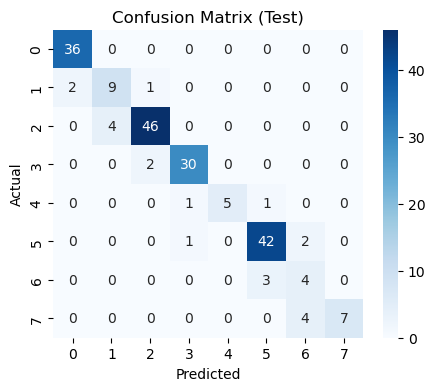

In [21]:
# ---------- 9) Evaluate best model on test set ----------
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:,1] if len(np.unique(y))==2 else None

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="binary" if len(np.unique(y))==2 else "weighted", zero_division=0)
rec = recall_score(y_test, y_pred, average="binary" if len(np.unique(y))==2 else "weighted", zero_division=0)
f1 = f1_score(y_test, y_pred, average="binary" if len(np.unique(y))==2 else "weighted", zero_division=0)

print("\nTest set results for best model:")
print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC if binary
if y_proba is not None:
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {auc:.4f}")
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.show()

In [22]:
# ---------- 10) Compare different kernel variants (quick cross-val comparison) ----------
models_to_compare = {
    "linear": SVC(kernel="linear", C=grid.best_params_.get("C",1), probability=True, random_state=42),
    "rbf": SVC(kernel="rbf", C=grid.best_params_.get("C",1), gamma=grid.best_params_.get("gamma","scale"), probability=True, random_state=42),
    "poly": SVC(kernel="poly", C=grid.best_params_.get("C",1), degree=grid.best_params_.get("degree",3), probability=True, random_state=42)
}

print("\nCross-validated F1/Accuracy comparison (5-fold):")
for name, m in models_to_compare.items():
    scores = cross_val_score(m, scaler.transform(X), y, cv=cv, scoring="f1" if len(np.unique(y))==2 else "accuracy", n_jobs=-1)
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")

# ---------- 11) Save the best model and scaler (optional) ----------
import joblib
joblib.dump(best_model, "svm_best_model.joblib")
joblib.dump(scaler, "svm_scaler.joblib")
print("\nSaved best model and scaler to disk: svm_best_model.joblib, svm_scaler.joblib")


Cross-validated F1/Accuracy comparison (5-fold):
linear: mean=0.9100, std=0.0095
rbf: mean=0.4390, std=0.0097
poly: mean=0.2740, std=0.0073

Saved best model and scaler to disk: svm_best_model.joblib, svm_scaler.joblib
